In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

TensorShape([60000, 10])

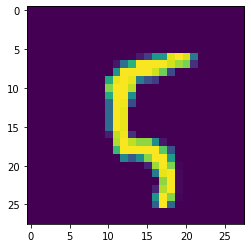

In [13]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

plt.imshow(x_train[100])
y_train.shape

In [14]:
batch_size = 64
epochs = 5

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)), #, kernel_regularizer=l2(0.01)
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                      

In [24]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True
    # Evaluate the model on the test set after each epoch
    test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)

    # If you want to use the test accuracy in your plot
    logs['test_acc'] = test_acc

callbacks = myCallback()

In [25]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
844/844 [==============================] - 69s 81ms/step - loss: 0.0423 - acc: 0.9881 - val_loss: 0.0284 - val_acc: 0.9930 - test_acc: 0.9921
Epoch 2/5
844/844 [==============================] - 67s 80ms/step - loss: 0.0415 - acc: 0.9884 - val_loss: 0.0285 - val_acc: 0.9922 - test_acc: 0.9922
Epoch 3/5
844/844 [==============================] - 68s 80ms/step - loss: 0.0408 - acc: 0.9889 - val_loss: 0.0301 - val_acc: 0.9918 - test_acc: 0.9937
Epoch 4/5
844/844 [==============================] - 67s 80ms/step - loss: 0.0441 - acc: 0.9887 - val_loss: 0.0255 - val_acc: 0.9933 - test_acc: 0.9929
Epoch 5/5
844/844 [==============================] - 67s 80ms/step - loss: 0.0457 - acc: 0.9881 - val_loss: 0.0288 - val_acc: 0.9932 - test_acc: 0.9936


In [29]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 12ms/step - loss: 0.0230 - acc: 0.9936


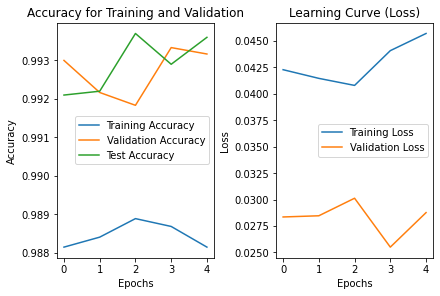

In [44]:
# 1. Plot accuracy for training, validation, and testing on one graph
fig, ax = plt.subplots(2,2,constrained_layout = True)
plt.subplot(121)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.plot(history.history['test_acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for Training and Validation')

# 2. Plot learning curve (loss)
plt.subplot(122)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve (Loss)')
plt.show()


/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  del sys.path[0]


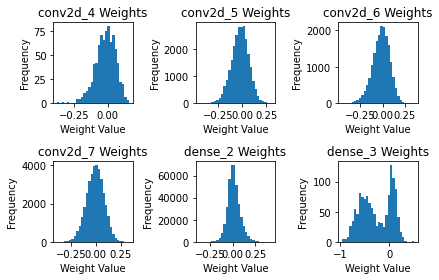

In [52]:
# 3. Histograms of each layer's weights
fig, ax = plt.subplots(2,3,constrained_layout = True)
i=0
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
        plt.subplot(2, 3, i+1)
        weights, biases = layer.get_weights()
        plt.hist(weights.flatten(), bins=30)
        plt.title(f'{layer.name} Weights')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        i = i+1
fig.tight_layout()
plt.show()

313/313 [==============================] - 4s 11ms/step


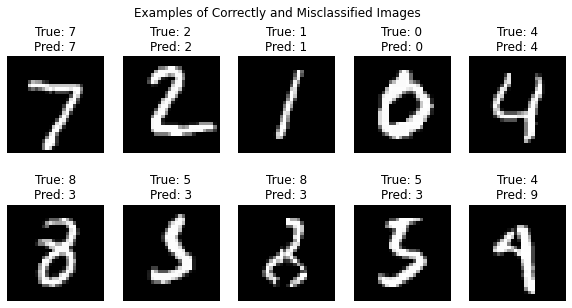

In [53]:
# 4. Show examples of correctly classified and miss-classified images
predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

correctly_classified_indices = np.where(y_pred == y_true)[0]
misclassified_indices = np.where(y_pred != y_true)[0]

# Display some correctly classified images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[correctly_classified_indices[i]], cmap='gray')
    plt.title(f'True: {y_true[correctly_classified_indices[i]]}\nPred: {y_pred[correctly_classified_indices[i]]}')
    plt.axis('off')

# Display some misclassified images
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(x_test[misclassified_indices[i]], cmap='gray')
    plt.title(f'True: {y_true[misclassified_indices[i]]}\nPred: {y_pred[misclassified_indices[i]]}')
    plt.axis('off')

plt.suptitle('Examples of Correctly and Misclassified Images')
plt.show()


1/1 [==============================] - 0s 86ms/step


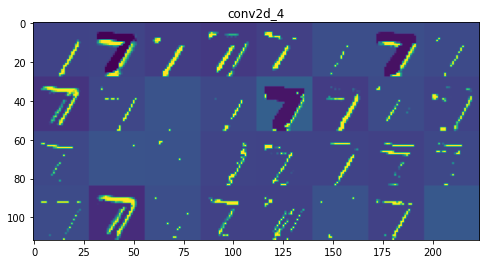

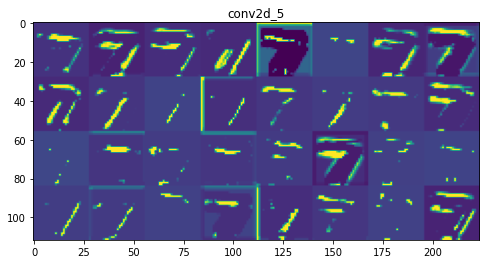

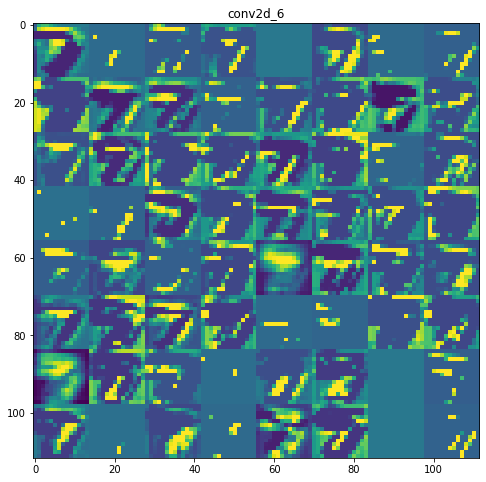

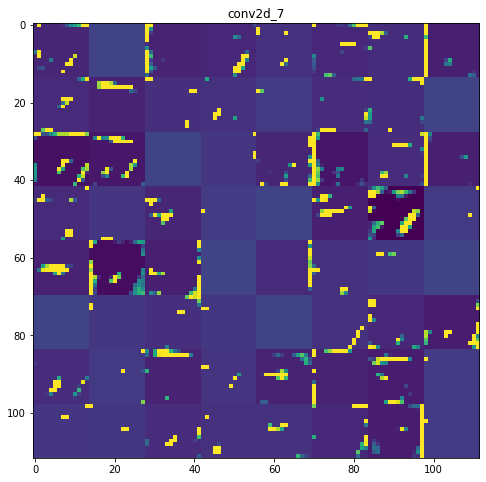

In [55]:
# Observe feature maps from different convolutional layers
layer_outputs = [layer.output for layer in model.layers[:6]]  # Extracting the output of the first six layers
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

example_image = x_test[0].reshape(1, 28, 28, 1)  # Take the first test image for visualization
activations = activation_model.predict(example_image)

# Plot the feature maps
layer_names = [layer.name for layer in model.layers[:6]]

for layer_name, layer_activation in zip(layer_names, activations):
    if 'conv' in layer_name:
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // 8  # Display up to 8 feature maps per row
        display_grid = np.zeros((size * n_cols, 8 * size))

        for col in range(n_cols):
            for row in range(8):
                channel_image = layer_activation[0, :, :, col * 8 + row]
                channel_image -= channel_image.mean()
                channel_image_std = channel_image.std()
                channel_image_std = channel_image_std if channel_image_std > 0 else 1e-10  # Avoid division by zero
                channel_image /= channel_image_std
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image


        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

In [ ]:
# There are a few points we can infer from this:

# This first layer retains almost the full shape of the image, and also most of the information present in the image
# As we go deeper into the network we can see that the activations become more complex and abstract. It starts encoding high-level features such as edges, curves and angles.
# Also as we go deeper we can see that many of our filters are not getting activated, which shows our model is reaching it’s learning capacity.